# Contents

### Module 3
- Advanced Circuit Visualizations
- QASM Export/Import
- Circuit Depth
- Qiskit Version
- Backend Overview & Gate/Error Maps (real QPU)
- Coupling Maps
- Sampler

### Advanced Circuit Visualization

Let's start with defining and visualizing a rather big circuit.

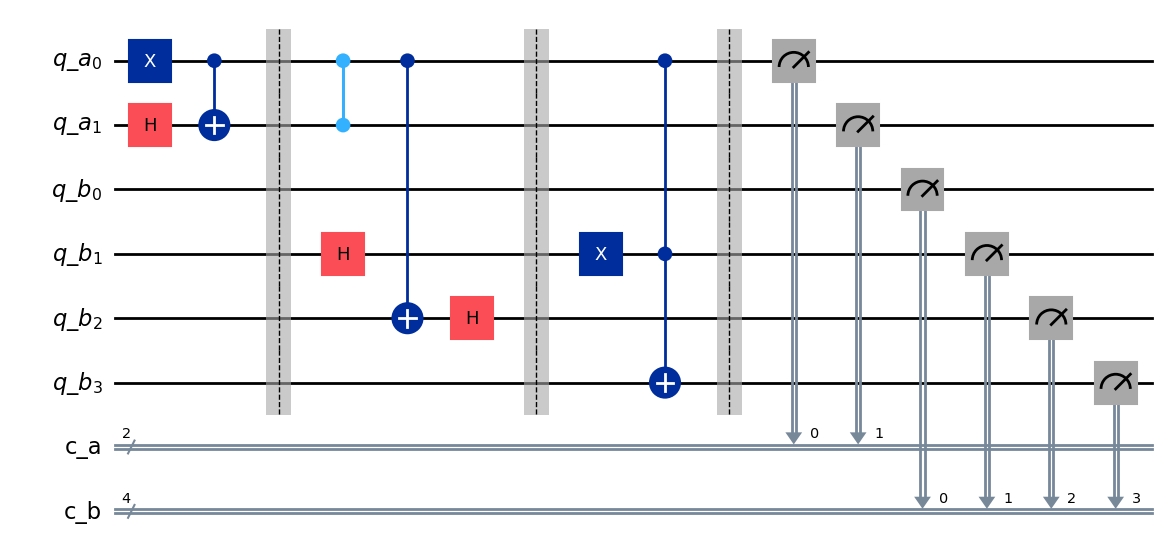

In [ ]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit

q_a = QuantumRegister(2, 'q_a')
q_b = QuantumRegister(4, 'q_b')
c_a = ClassicalRegister(2, 'c_a')
c_b = ClassicalRegister(4, 'c_b')

qc = QuantumCircuit(q_a, q_b, c_a, c_b)

qc.x(0)
qc.h(1)
qc.cx(0,1)
qc.barrier()
qc.cz(0,1)
qc.cx(0,4)
qc.h(3)
qc.h(4)
qc.barrier()
qc.x(3)
qc.ccx(0,3,5)
qc.barrier()
qc.measure(q_a, c_a)
qc.measure(q_b, c_b)
qc.draw('mpl')

Now that we have a circuit, let's explore 4 nice parameters we can use to modify our circuit graphics.

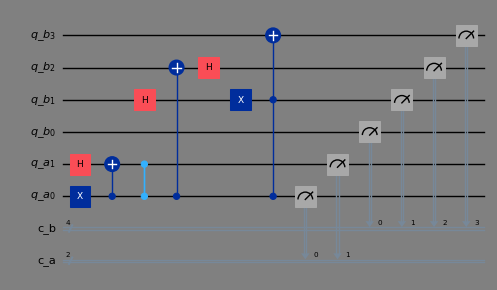

In [ ]:
qc.draw('mpl', reverse_bits=True, plot_barriers=False, scale=0.5, style = {'backgroundcolor' : 'gray'})

It's also just good to remember that there's actually a direct circuit drawer function instead of using the .draw() on the circuit.

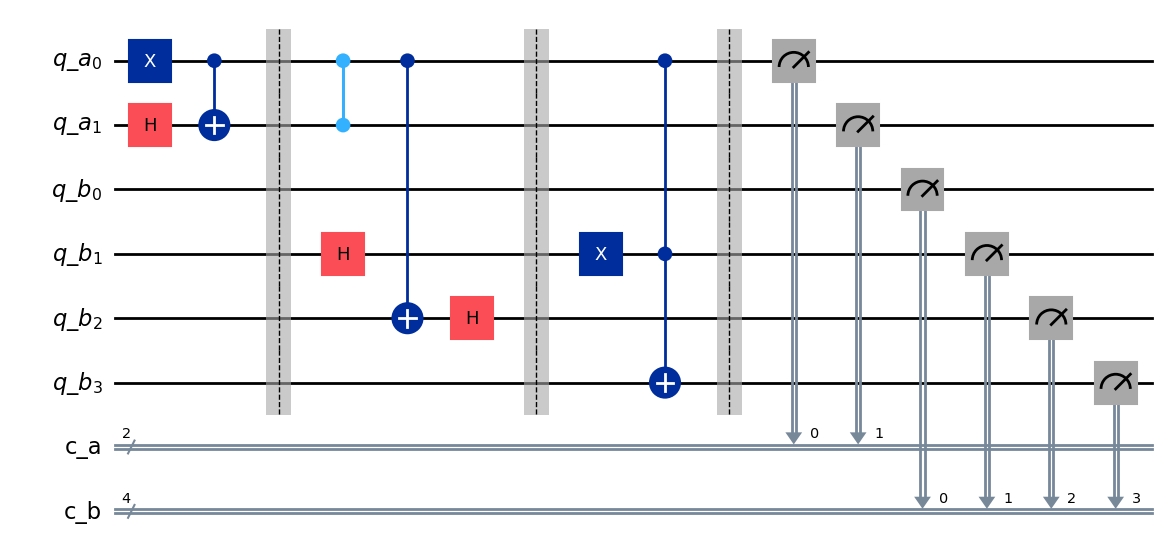

In [ ]:
from qiskit.visualization import circuit_drawer

circuit_drawer(qc, output='mpl')

### QASM Export/Import

We've done a lot of simulating with QASM in Module 2. Let's now see how we can export to and import from QASM files. This is useful for projects that use coding in multiple Quantum SDKs, so that everyone can share circuits they have created in one standard form, which is QASM. Let's demonstrate how we can achieve this within Qiskit by creating a GHZ circuit.

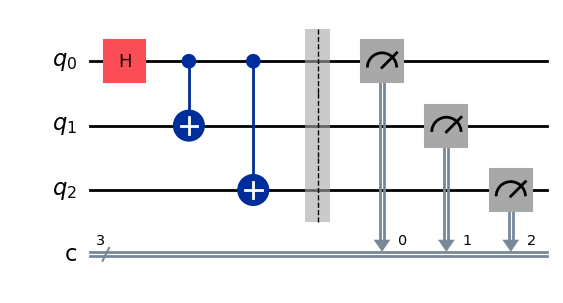

In [34]:
qc = QuantumCircuit(3,3)
qc.h(0)
qc.cx(0,1)
qc.cx(0,2)
qc.barrier()
qc.measure([0,1,2], [0,1,2])
qc.draw('mpl')

Now that we have our circuit, all we have to do is use `dumps` on it to create a QASM string.

In [ ]:
import qiskit.qasm2 as qasm2

qasm_str = qasm2.dumps(qc)
qasm_str


'OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[3];\ncreg c[3];\nh q[0];\ncx q[0],q[1];\ncx q[0],q[2];\nbarrier q[0],q[1],q[2];\nmeasure q[0] -> c[0];\nmeasure q[1] -> c[1];\nmeasure q[2] -> c[2];'

Voila! We now have a QASM string that can be used directly. Let's also import it to double check that it worked.

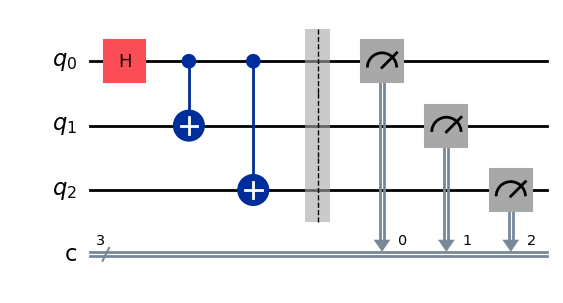

In [35]:
circ = QuantumCircuit.from_qasm_str(qasm_str)
circ.draw('mpl')

It indeed works correctly.

### Circuit Depth

We will now see how to obtain the depth of a circuit and how a barrier changes things.

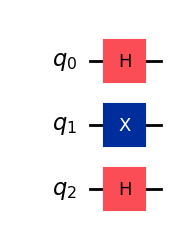

In [ ]:
from qiskit import QuantumCircuit, transpile
from qiskit.providers.fake_provider import FakeVigo

circ = QuantumCircuit(3)
circ.h(0)
circ.x(1)
circ.h(2)
circ.draw('mpl')

We can directly call the .depth() method to print out the depth of this circuit.

In [ ]:
print("Circuit depth:", circ.depth())

# Function to calculate 2-qubit depth
def two_qubit_depth(circuit):
    return sum(1 for gate in circuit.data if len(gate.qubits) == 2)

print("2-qubit gate depth:", two_qubit_depth(circ))

1

As expected, the depth is 1. Let's now add a barrier to the middle of the circuit and see what happens.

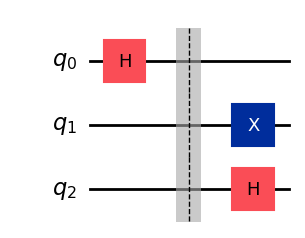

In [37]:
circ = QuantumCircuit(3)
circ.h(0)
circ.barrier()
circ.x(1)
circ.h(2)
circ.draw('mpl')

In [10]:
circ.depth()

2

This is a direct demonstration of what we've talked in Module 2 about Barriers. The barrier not only acts as a visual separator to keep your circuits looking clean, but also as a directive for the backends to execute the circuit in batches. Since we have a barrier mid-circuit here, we created 2 batches and the circuit depth has become 2.

### Qiskit Version

Are you having problems with some packages you're using along with Qiskit? Are you getting weird error messages?
First thing to check is your Qiskit version in such a case. It's very simple.

In [11]:
import qiskit
qiskit.__version__

'1.2.1'

### Backend Overview & Gate/Error Maps

We could simply go to our Dashboard and check which machines are available to us.
However, we are also able of checking which machines are available to us directly from our notebook environment.

In [63]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(
    channel="ibm_quantum",
    token="<IBM-TOKEN>")

In [22]:
service.backends()

[<IBMBackend('ibm_brisbane')>,
 <IBMBackend('ibm_kyiv')>,
 <IBMBackend('ibm_sherbrooke')>]

In [27]:
real_backend = service.backend("ibm_brisbane")

That already gives us a good overview, but what if we required more specific information about the couplings within the chip and their specific specs. Error rates depend very much on fabrication, and even within the same chip we can have different two qubit gate error rates between different qubits. When running experiments on real devices, it's always good practice to get as much information about the chip you will be using and use the two qubits with lowest error rates if it's possible.

First of all, let's print out one of the 127 qubit chips available to us.

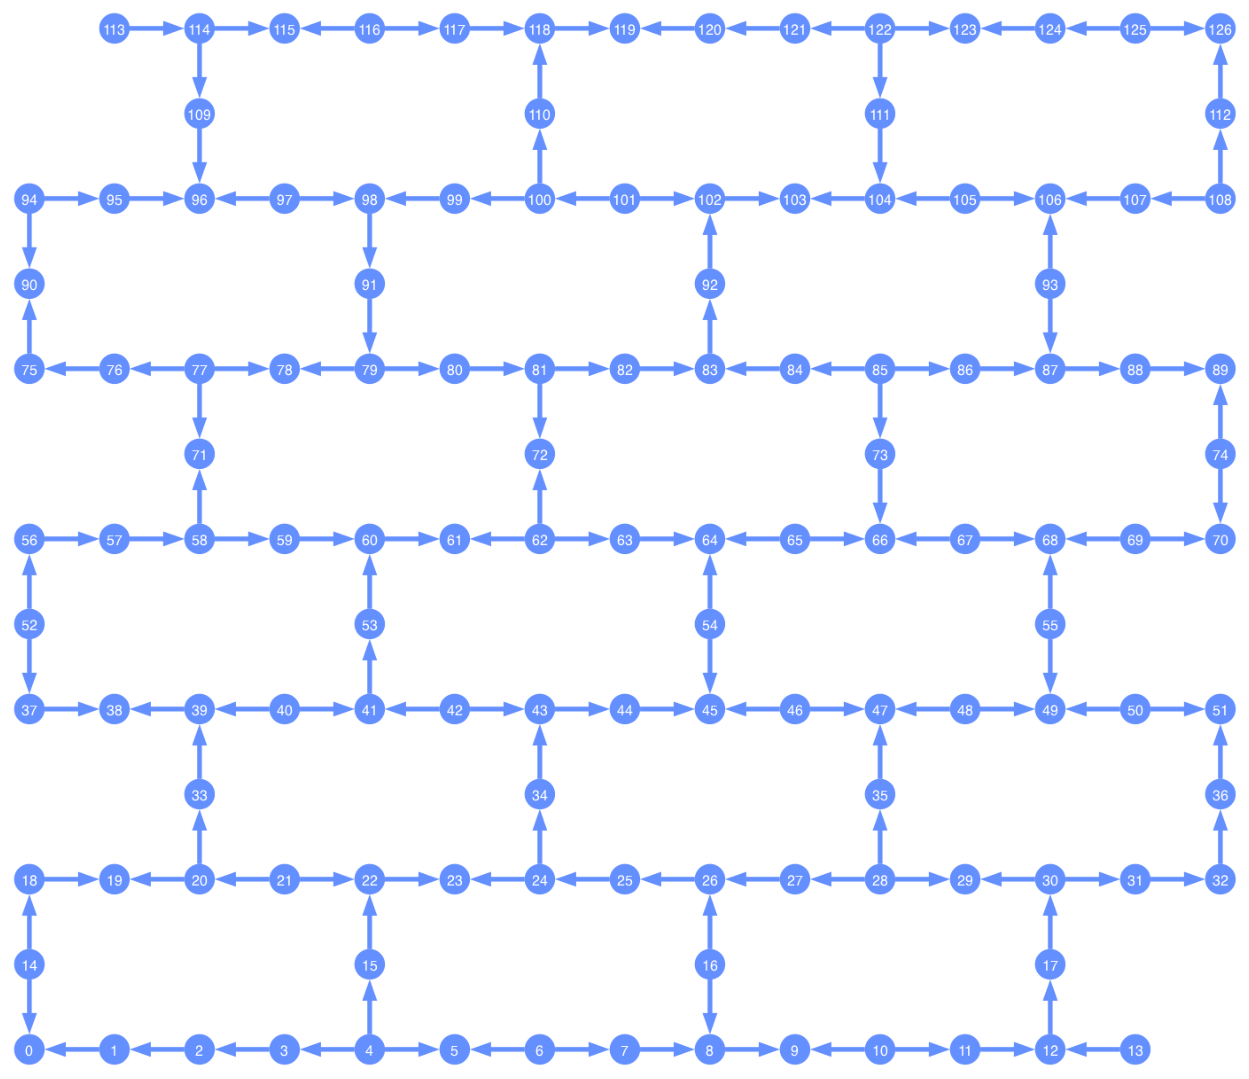

In [28]:
from qiskit.visualization import plot_gate_map

plot_gate_map(real_backend, plot_directed=True)



Then, let's obtain the error information.

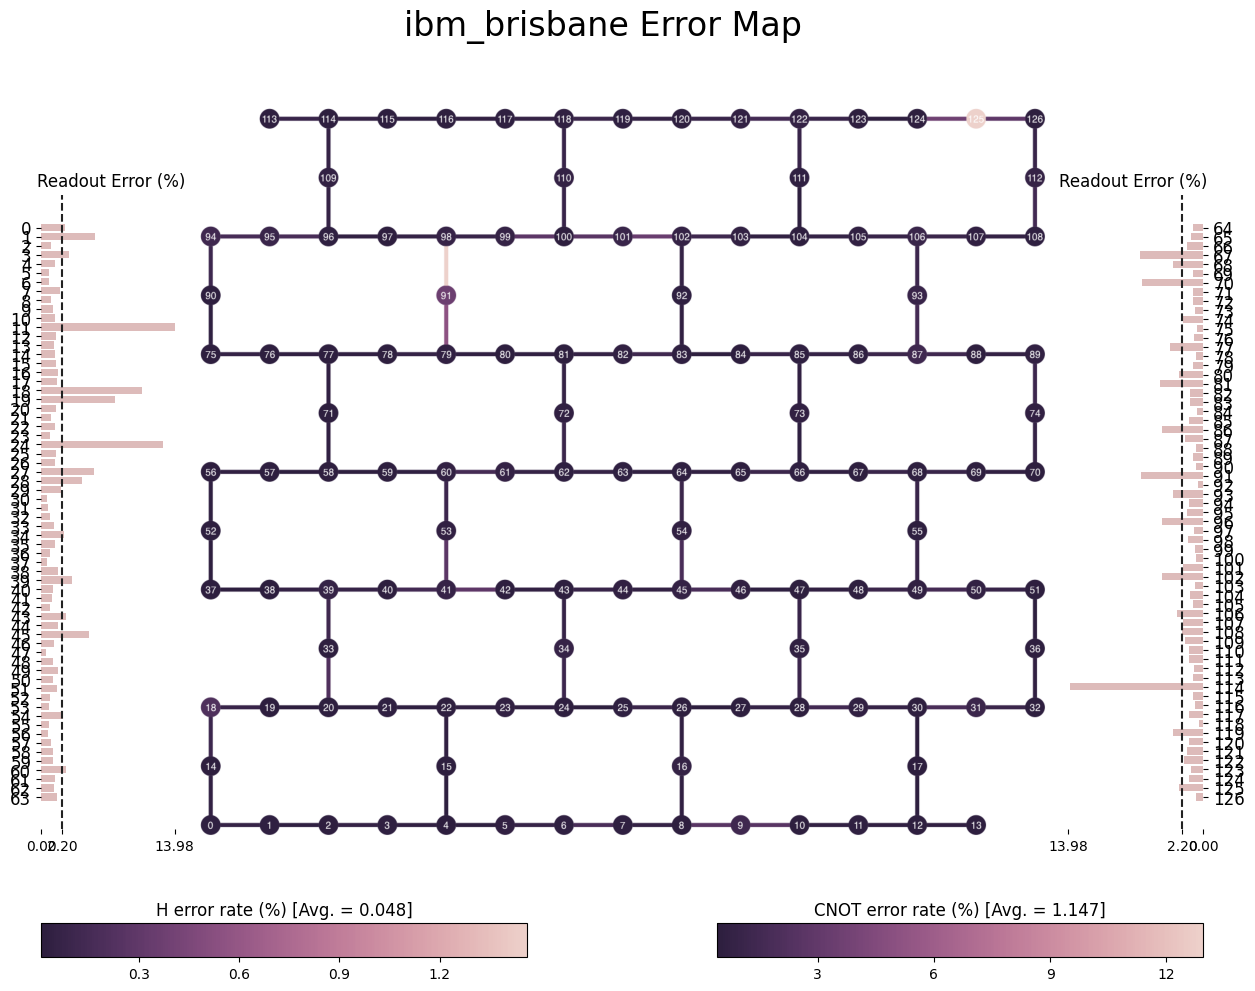

In [29]:
from qiskit.visualization import plot_error_map

plot_error_map(real_backend)

To visualize the readout error rates better, let us look at a smaller QPU.

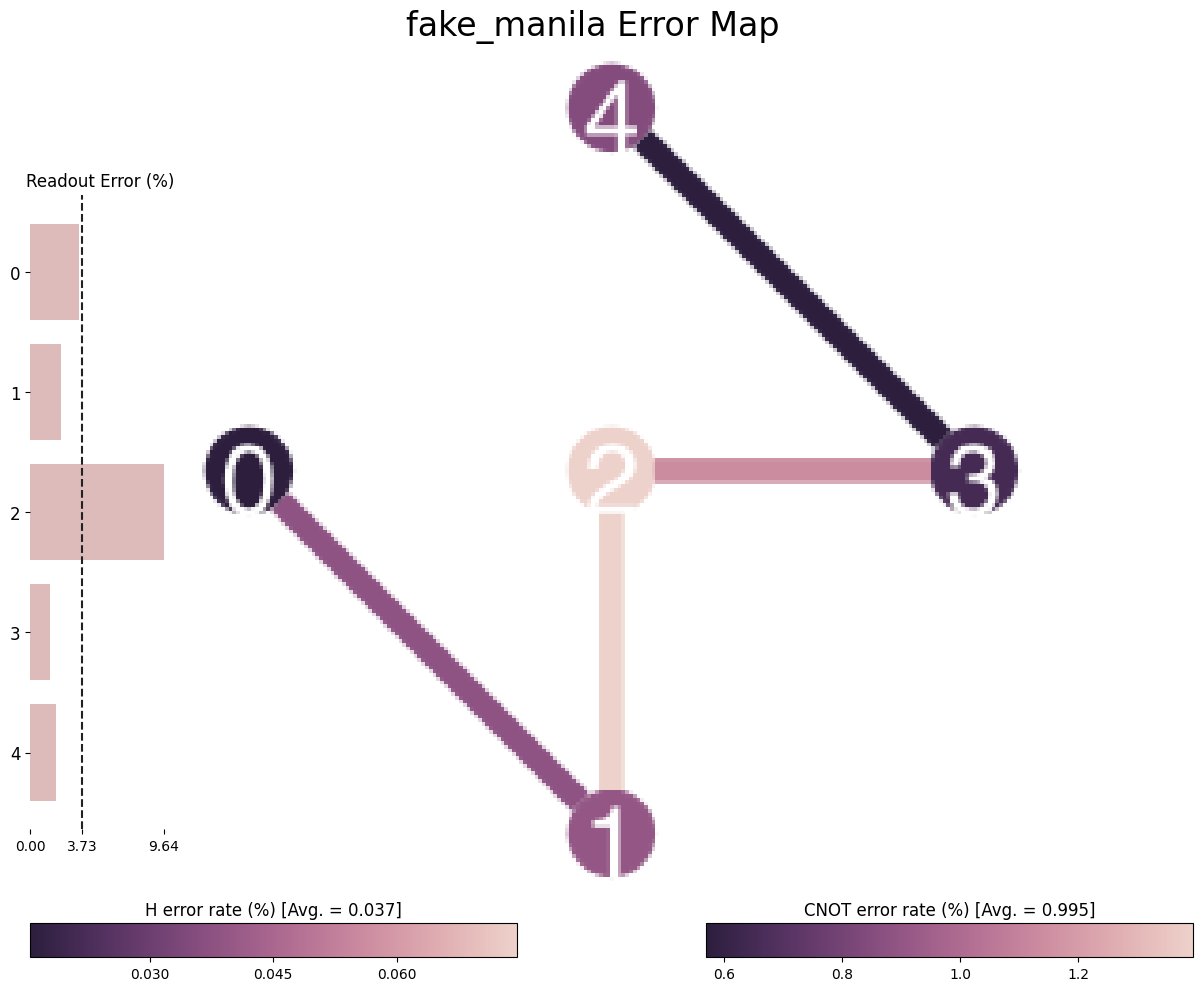

In [48]:
# Define a local backend using qiskit runtime
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
backend = FakeManilaV2()
plot_error_map(backend)

Alternatively, we can also define a generic fake backend emulating a real QPU with any desired chracteristics. For example, we can choose a 3 qubit code with a linear chain of qubits and visualize its errors.

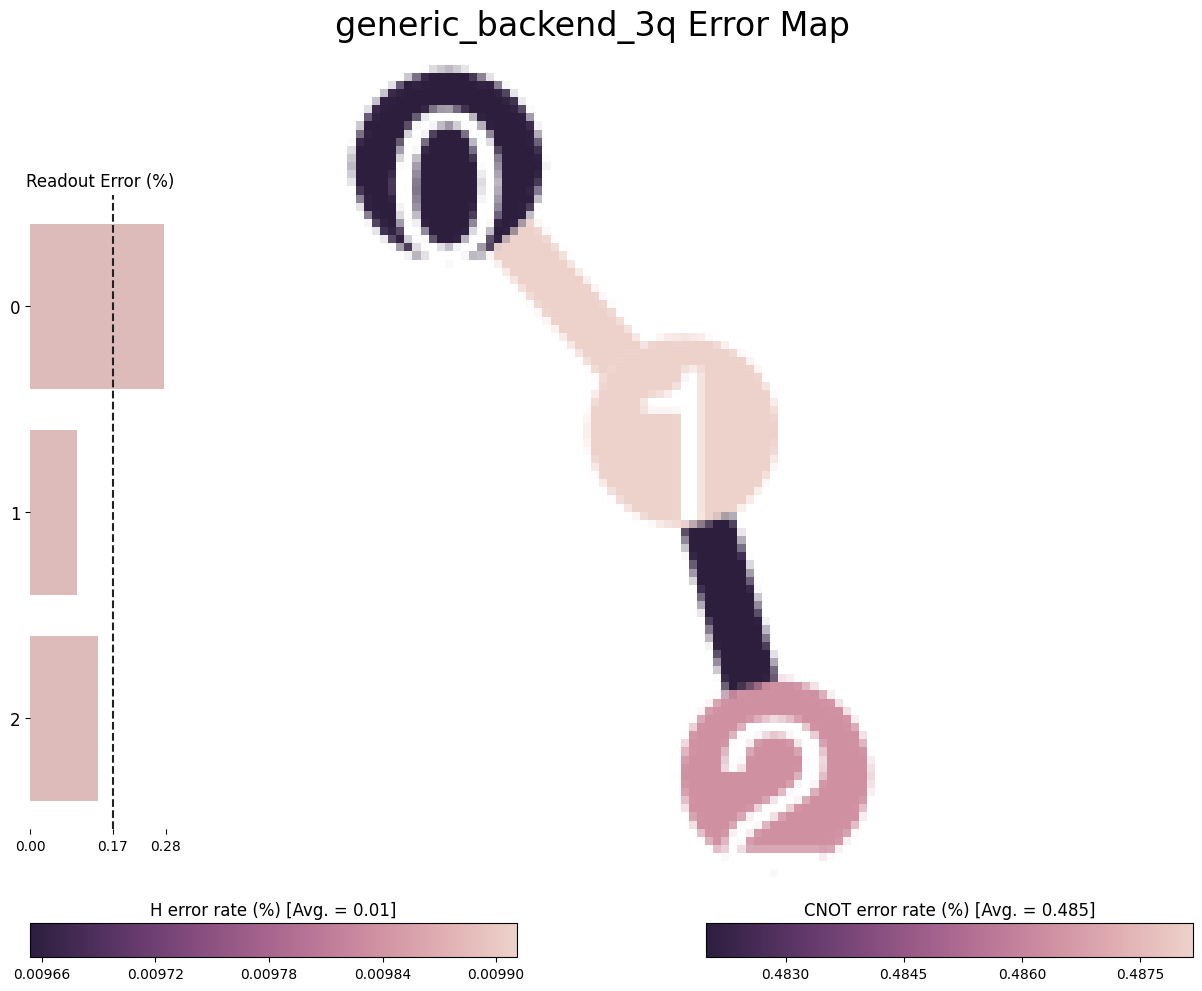

In [44]:
from qiskit.providers.fake_provider import GenericBackendV2

coupling_map = [[0,1],[1,2]]
fake_backend = GenericBackendV2(num_qubits=3, coupling_map=coupling_map)

plot_error_map(fake_backend)

### Coupling Maps

We can then use the coupling map of this backend for running a simulation. Coupling maps are usually used to model the hardware constraints, and in this case we will use them to transpile the quantum circuit.

In [59]:
# from qiskit.providers.basic_provider import BasicSimulator
from qiskit import transpile


qc = QuantumCircuit(3)
qc.measure_all()

transpiled_circuit = transpile(qc, backend)
result = backend.run(transpiled_circuit, shots=1000).result()
counts = result.get_counts()
print(counts)


{'001': 13, '100': 52, '010': 12, '101': 1, '000': 922}


In [ ]:
from qiskit_ibm_runtime import Sampler

sampler = Sampler(backend)
job = sampler.run([qc])
print(f"job id: {job.job_id()}")
result = job.result()
# Get results for the first (and only) PUB
pub_result = result[0]

# Get counts from the classical register "meas".
print(f" >> Meas output register counts: {pub_result.data.meas.get_counts()}")

job id: 67833099-f9a0-4bce-a19f-6e0bb21703b8
 >> Meas output register counts: {'001': 13, '000': 920, '100': 77, '011': 2, '010': 9, '101': 3}


That's it! Hope you enjoyed it :)